In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from paths import RAW_DIR, STAGE_DIR
from display import cdisplay
from functions import get_populations, cost_analysis, risk_analysis
from plots import plot_risk_cost_reduction

In [3]:
data = pd.read_parquet(STAGE_DIR / 'process' / 'predictions.parquet')
data_univariate = pd.read_parquet(STAGE_DIR / 'process' / 'predictions_univariate.parquet')
data_multivariate = pd.read_parquet(STAGE_DIR / 'process' / 'predictions_multivariate.parquet')

In [4]:
TARGET = 'HeartDiseaseorAttack'
POST_TREATMENT_COST = 50000
PLAN_COST = 1000
REDUCTION_GOAL_PERCENTAGE = 0.8
ACCEPTANCE_PERCENTAGE = 0.85
RISK_REDUCTION_PERCENTAGE = 0.25

# Basic cost analysis

The basic cost analysis strategy aims to know the plan's adherance percentage needed to achieve the 20% cost's reduction. The model output is used to select the most vulnerable population to be offer the plan and reducing also the heart attack risk in the population.

$$
R = A * 1000 + (N - A) * 50000 \\
R = A * 1000 - A * 50000 + N * 50000 \\
R = -49000 * A + N * 50000 \\
A = \frac{N * 50000 - R}{49000}
$$

[a, c, d, wef, wf, w, qe]

[0.1, 0.2, 0.3, 0.4, 0.5, ...]

=> t_1 = 0.5  => N = |P_{p>= 0.5}| => offer

=> t_2 = 0.3  => N = |P_{p>= 0.3}| => offer

=> t_3 = 0.2  => N = |P_{p>= 0.2}| => offer

threholds = [...]

costs = [cost_analysis(...) for t in thresholds]

sns.lineplot(x=thresholds, y=costs)

In [5]:
adherance_percentage, reduced_cost = cost_analysis(
    df=data,
    prob_column='proba',
    target_column=TARGET,
    reduction_goal=REDUCTION_GOAL_PERCENTAGE,
    acceptance_percentage=ACCEPTANCE_PERCENTAGE,
    pre_cost=PLAN_COST,
    post_cost=POST_TREATMENT_COST
)

population_amount=23893
baseline_cost=1194650000
reduced_cost=955720000.0
adherence_amount=4876.122448979592
adherence_percentage=0.24009603841536617


In [6]:
offer_df, _, adherance_df = get_populations(
    df=data,
    prob_column='proba',
    target_column=TARGET,
    acceptance_percentage=ACCEPTANCE_PERCENTAGE,
    adherence_percentage=adherance_percentage
)

In [7]:
risk_analysis(offer_df, adherance_df, 'proba', RISK_REDUCTION_PERCENTAGE)

mean_baseline_risk=0.5202128641045853
mean_reduced_risk=0.44049528102992624


0.44049528102992624

adherence_percentages=array([0.24009604, 0.34009604, 0.44009604, 0.54009604, 0.64009604,
       0.74009604, 0.84009604, 0.94009604])
mean_risk_reductions=[0.4267966086702872, 0.38659935898169184, 0.34868571646448343, 0.3099271102926854, 0.2705500768799787, 0.23152836084449416, 0.19263418820280007, 0.15349212112814464]
cost_reductions=[913555882.3529412, 796480182.3529412, 679404482.3529413, 562328782.352941, 445253082.35294104, 328177382.35294104, 211101682.35294104, 94025982.35294104]


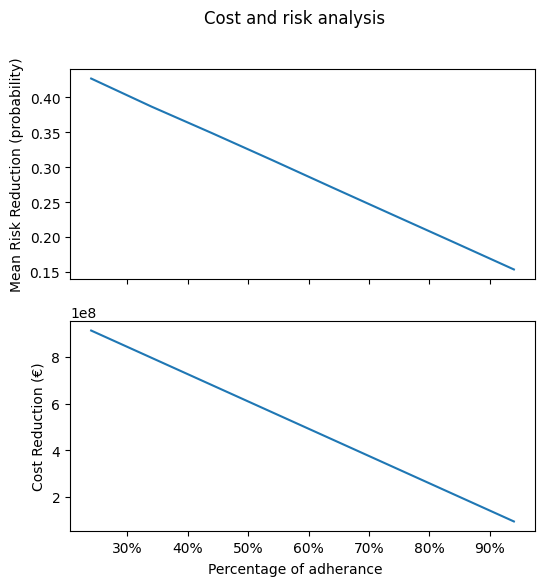

In [8]:
plot_risk_cost_reduction(
    df=offer_df,
    prob_column='proba',
    risk_reduction=RISK_REDUCTION_PERCENTAGE,
    base_adherance_percentage=adherance_percentage,
    post_cost=POST_TREATMENT_COST,
    pre_cost=PLAN_COST
)

# Complex cost analysis

With the basic aproach, we are leaving outside the fact that if a person doesn't adhere to the plan, then they are still prone to have a heart attack or disease, reporting a cost of €51 000 (€1000 for the plan and €50 000 for the treatment after they have the heart disease). Also, we are not taking into account that the risk reduction is only of 75% if they adhere to the plan. So, if they are above a threshold, then, they can still have a heart attack and cost also €51 000.

For that reason, we have the following cases:
* people adhere to the plan ($A$):
    * $A_1$ = original risk * 0.25 < threshold => Will not have a heart disease or attack in the future => cost = 1000
    * $A_2$ = original risk * 0.25 >= threshold => Will have a heart disease or attack in the future => cost = 51000
* people don't adhere to the plan, but accept it ($\neg{A}$):
    * we will assume they are going to have a heart disease or attack in the future => cost = 51000

$$
A = A_1 + A_2 \\

O = A_c + \neg{A_c} \\

A_c = A + \neg{A} \\
$$
---
$$
R = A_1 * 1000 + A_2 * 51000 + \neg{A_c} * 50000 + (A_c - A) * 51000 \\

R = A_1 * 1000 + A_2 * 51000 + \neg{A_c} * 50000 + (A_c - A_1 - A_2) * 51000 \\

R = A_1 * 1000 + A_2 * 51000 + \neg{A_c} * 50000 + A_c * 51000 - A_1 * 51000 - A_2 * 51000 \\

R = A_1 * 1000 + \neg{A_c} * 50000 + A_c * 51000 - A_1 * 51000 \\

R = \neg{A_c} * 50000 + A_c * 51000 - A_1 * 50000 \\

R = \neg{A_c} * 50000 + A_c * 50000 + A_c * 1000 - A_1 * 50000 \\

R = 50000 * (\neg{A_c} + A_c) + A_c * 1000 - A_1 * 50000 \\

R = 50000 * O + A_c * 1000 - A_1 * 50000 \\

A_1 = \frac{50000 * O + A_c * 1000 - R}{50000}
$$

In [9]:
# get amount of people
population_amount = data[data[TARGET].eq(1)].shape[0]
print(f'{population_amount=}')
# get baseline cost to reduce with the plan
baseline_cost = population_amount * POST_TREATMENT_COST
print(f'{baseline_cost=}')
# get reduced cost
reduced_cost = baseline_cost * REDUCTION_GOAL_PERCENTAGE
print(f'{reduced_cost=}')
# get amount of people that will accept the plan
accept_amount = population_amount * ACCEPTANCE_PERCENTAGE

# amount of people that should adhere the plan in order to achieve the goal
adherence_amount_1 = (baseline_cost + accept_amount * PLAN_COST - reduced_cost) / POST_TREATMENT_COST
print(f'{adherence_amount_1=}')
# get percentage of adherance
adherence_percentage_1 = adherence_amount_1 / accept_amount
print(f'{adherence_percentage_1=}')

population_amount=23893
baseline_cost=1194650000
reduced_cost=955720000.0
adherence_amount_1=5184.781
adherence_percentage_1=0.25529411764705884


In [11]:
offer_df, accept_df, _ = get_populations(data, 'proba', TARGET, ACCEPTANCE_PERCENTAGE)
threshold = offer_df['proba'].min()
print(f'{threshold=}')

threshold=0.27009123006071234


With the data and the population we are working on, no matter which people adhere to the plan, they are always going to fall bellow the risk threshold. In that case $A_2 = 0$ for every subset of the population who accepted the plan. Therefore, $A = A_1$.

In [16]:
below_threshold_amount = (accept_df['proba'] * RISK_REDUCTION_PERCENTAGE).lt(threshold).sum()
below_threshold_amount == accept_df.shape[0]

True